<a href="https://colab.research.google.com/github/bsaha205/Fall_22_PML/blob/main/PML_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1



**Framework:** Pytorch

**Dataset:** FashionMNIST from torchvision.datasets (https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).

**Resources:**
1. Optimizer: I used Adam optimizer from torch.optim (https://pytorch.org/docs/stable/optim.html).
2. MLP: Used torch.nn for implementing 2-layer NN model (https://pytorch.org/docs/stable/nn.html).
3. Plot: For plotting the data, I used matplotlib.pyplot library (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html).
4. Loss function: For loss function, I used cross_entropy loss from F.cross_entropy (https://pytorch.org/docs/stable/nn.functional.html).
5. Class Identify: To identify right class, I used log_softmax from F.log_softmax (https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html).

# Task 2

## Exploratory Data Analysis

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import joblib
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [80]:
# read FashionMNIST data from torchvision.datasets
train_data = datasets.FashionMNIST('.', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.FashionMNIST('.', train=False, transform=transforms.Compose([transforms.ToTensor()]))

# print("train_data:", torch.take(train_data, [0,1]))
# In the first step we will split train data in training and validation dataset. As we have seperate test dataset we don't need that.
# train_data, valid_data, train_target, valid_target = train_test_split(train_data.data, train_data.targets, test_size=0.15, random_state=42)
# train_data, valid_data = train_test_split(train_data.data, test_size=0.15, random_state=42)

# train_data = {}
# train_data['data'] = tr_data
# train_data['targets'] = tr_target

# print the shape of the dataset
print("train images:", train_data.data.size())
# print("valid_data images:", valid_data.size())
print("test images:", test_data.data.size())

train images: torch.Size([60000, 28, 28])
test images: torch.Size([10000, 28, 28])


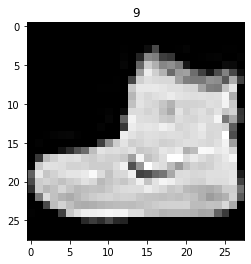

In [81]:
# plot the very first image of train dataset with label
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

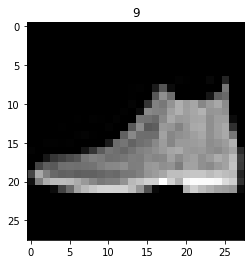

In [82]:
# plot the very first image of test dataset with label
plt.imshow(test_data.data[0].numpy(), cmap='gray')
plt.title('%i' % test_data.targets[0])
plt.show()

## Model

In [83]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        '''in_dim: input layer dim
           hidden_dim: hidden layer dim
           out_dim: output layer dim'''
        
        super(MLP, self).__init__()
        
        # images are 28x28 so we need to flatten them into 784d vector
        self.flatten = nn.Flatten()
        
        #two fully connected layers
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # x is 28x28, flatten it first
        x = self.flatten(x)
        
        # compute output of fc1, and then apply relu activation
        x = F.relu(self.fc1(x))
        
        # compute output layer
        # no activation: cross entropy will compute softmax
        x = self.fc2(x)
        return x

## Training

In [84]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

#hyper-paramets defining
batch_size = 1000
learning_rate = 0.01
epochs = 5
in_dim = 28 # images are 28x28 as inputs
hidden_dim = 256 # 384d hidden layer
number_of_class = 10 # output is 10d since there are 10 classes

# set model
model = MLP(in_dim*in_dim, hidden_dim, number_of_class)

# optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# load training data in batches
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
# send model over to device
model = model.to(device)
model.train()

using device: cpu


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Training loop over batches

In [87]:
for epoch in range(1, epochs + 1):    
    sum_valid_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):

        # send batch over to device
        data, target = data.to(device), target.to(device)
        
        # zero out prev gradients
        optimizer.zero_grad()
        
        # run the forward pass
        output = model(data)
        
        # compute loss/error
        loss = F.cross_entropy(output, target)

        # I used first 50000 datapoints of train_data as trainig dataset and last 10000 points as validation dataset
        if batch_idx >= 50:
          # sum up batch losses for validation dataset
          sum_valid_loss += loss.item()
          continue
        
        # compute gradients and take a step in training phase
        loss.backward()
        optimizer.step()
        
    # average loss per example    
    sum_valid_loss /= 10000
    print(f'Epoch: {epoch}, Validation Loss: {sum_valid_loss:.6f}')

Epoch: 1, Validation Loss: 0.000320


KeyboardInterrupt: ignored

## Testing

In [86]:
# load test images in batches
test_loader = du.DataLoader(dataset=test_data,
                            batch_size=batch_size,
                            shuffle=True)

# set model in eval mode as we are no longer training
model.eval()
test_loss = 0
correct = 0

# turning of gradient computation that will speed up testing
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # send batches to device
        data, target = data.to(device), target.to(device)
        
        # compute forward pass and loss
        output = model(data)
        loss = F.cross_entropy(output, target)
        
        # sum up batch loss
        test_loss += loss.item()

        # get the class of the max log-probability
        output = F.log_softmax(output, dim=1)
        pred = output.max(dim=1)[1]

        # add up number of correct predictions
        correct += torch.sum(pred == target)
  
    # test loss per example
    test_loss /= len(test_loader.dataset)
    
    # final test accuracy
    test_acc = correct / len(test_loader.dataset)
    print(f'Test loss: {test_loss:.6f}, accuracy: {test_acc:.4f}', f'correct: {correct}')

Test loss: 0.000376, accuracy: 0.8646 correct: 8646
